In [46]:
from datasets import load_dataset
import numpy as np
import tqdm
import time

In [2]:
ds = load_dataset("habanoz/haber-90k-gpt-text")

In [26]:
ds1000 = ds['train'].shuffle().take(1000)

In [27]:
ds1000

Dataset({
    features: ['text'],
    num_rows: 1000
})

In [110]:
class ScoreQueue:
    def __init__(self, limit=1000):
        self.limit = limit
        self.h = []
        self.insert_count = 0
    @property
    def size(self):
        return len(self.h)
    
    def add(self, i,j, score):
        if self.size < self.limit-1:
            self.h.append((score, i,j))
        elif self.size == self.limit-1:
            self.h.append((score, i,j)) # O(1)
            self.h.sort(reverse=True) # O(NlogN)
            
            print("List is filled up!")
        else:
            if self.h[-1][0]<score:
                self.h.pop() # O(1)
                self.h.append((score, i,j)) # O(1)
                self.h.sort(reverse=True) # O(N) (already sorted)
                
                self.insert_count += 1
    
    def get_list(self):
        self.h.sort(reverse=True)
        return list(map(lambda x: (x[1], x[2], x[0]), self.h ))
        

In [111]:
from heapq import heapify, heappushpop

class ScoreHQueue:
    def __init__(self, limit=1000):
        self.limit = limit
        self.h = []
        self.push_counts = 0
    
    @property
    def size(self):
        return len(self.h)
    
    def add(self, i,j, score):
        if self.size < self.limit-1:
            self.h.append((score, i,j))
        elif self.size == self.limit-1:
            self.h.append((score, i,j))
            heapify(self.h) # O(N)
            
            print("Heap is filled up!")
        else:
            if self.h[0][0]<score: # h[0] is the smallest value in the min heap
                heappushpop(self.h, (score, i,j)) # O(logN)
                self.push_counts+=1
                
    def get_list(self):
        self.h.sort(reverse=True)
        return list(map(lambda x: (x[1], x[2], x[0]), self.h ))
        

In [112]:
from sklearn.feature_extraction.text import CountVectorizer

class MinHash:
    def __init__(self, n_hashes, q_limit=1000, binary=True, seed=123, approximate=True, use_h_queue=False):
        self.cv = None
        rng = np.random.default_rng(seed)
        self.cv = CountVectorizer(binary=binary, ngram_range=(1,1), analyzer="word")
        
        self.next_prime = 4294967311
        max_token_value = 2 ** 32 - 1
        self.n_hashes = n_hashes
        self.q_limit = q_limit
        self.approximate = approximate
        self.use_h_queue = use_h_queue
        
        self.A = rng.integers(0, max_token_value, n_hashes, dtype=np.int64)
        self.B = rng.integers(0, max_token_value, n_hashes, dtype=np.int64)
        

    def _fit(self, corpus):
        self.cv.fit(corpus)
    
    def _sparse_vectorize(self, text_list):
        return self.cv.transform(text_list).tolil().rows

    def _create_signature(self, sparse_vector):
        signature = np.matmul(np.asarray(sparse_vector).reshape(-1,1), self.A.reshape(1,-1))
        signature += self.B
        signature %= self.next_prime
        signature = signature.min(axis=0)
        return signature

    def _create_pairs(self, signatures):
        q = ScoreHQueue(limit=self.q_limit) if self.use_h_queue else ScoreQueue(limit=self.q_limit) 
        k,h = signatures.shape
        
        for i in tqdm.tqdm(range(k)):
            # broadcast and subtract from the remaining of the matrix
            matches = (signatures[i]-signatures[i+1:,:])==0
            scores = matches.sum(axis=1) / h
            
            for j, score in zip(range(i+1, k), scores):
                q.add(i,j, score)
        
        return q.get_list()
    
    def _create_pairs_exact(self, signatures):
        q = ScoreHQueue(limit=self.q_limit) if self.use_h_queue else ScoreQueue(limit=self.q_limit) 
        k,h = signatures.shape
        
        for i in tqdm.tqdm(range(k)):
            set_i = set(signatures[i])
            for j in range(i+1, k):
                set_j = set(signatures[j])
                score = len(set_i & set_j) / len(set_i | set_j)
                q.add(i,j, score)
        
        return q.get_list()

    def generate_scores(self, text_list):
        self._fit(text_list)
        sparse_vector = self._sparse_vectorize(text_list)
        signatures = np.asarray([ self._create_signature(v) for v in sparse_vector])
        
        if self.approximate:
            return self._create_pairs(signatures)
        else:
            return self._create_pairs_exact(signatures)
    
    

## Test Basic Varations

In [49]:
def test_scale(dims):
    times = []
    sums = []
    for dim in dims:
        corpus = ds['train'].take(dim)['text'][:]
        
        t0 = time.time()
        mhs = MinHash(10, binary=True, approximate=True)
        pairs1 = mhs.generate_scores(corpus)
        
        t1 = time.time()
        mhs = MinHash(10, binary=False, approximate=True)
        pairs2 = mhs.generate_scores(corpus)
        
        t2 = time.time()
        mhs = MinHash(10, binary=False, approximate=False)
        pairs3 = mhs.generate_scores(corpus)
        
        t3 = time.time()
        
        times.append((t1-t0, t2-t1, t3-t2))
        
        sum1=0
        for i in range(len(pairs1)):
            if pairs1[i][0]==pairs2[i][0] and pairs1[i][1]==pairs2[i][1]:
                sum1+=1
        print(sum1)
        
        sum2=0
        for i in range(len(pairs1)):
            if pairs1[i][0]==pairs3[i][0] and pairs1[i][1]==pairs3[i][1]:
                sum2+=1
        print(sum2)
        
        sums.append((sum1, sum2))
    return times, sums

In [50]:
times, sums = test_scale([1000, 3_000, 10_000, 30_000])

100%|██████████| 1000/1000 [00:01<00:00, 803.63it/s]


1000
1000


100%|██████████| 3000/3000 [00:10<00:00, 272.91it/s] 


1000
1000


100%|██████████| 10000/10000 [02:57<00:00, 56.49it/s]


1000
1000


100%|██████████| 30000/30000 [26:41<00:00, 18.73it/s] 


1000
1000


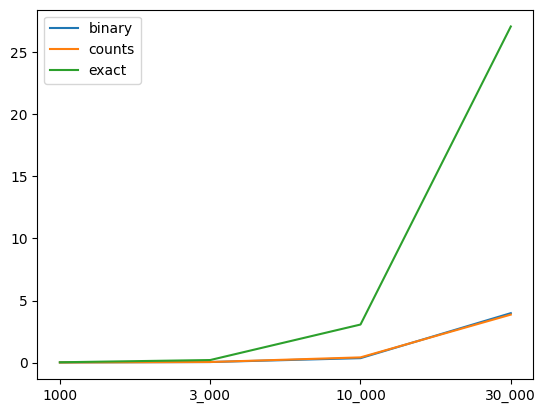

In [64]:
import matplotlib.pyplot as plt
on_list = [t[0]/60 for t in times]
on_heap = [t[1]/60 for t in times]
exact = [t[2]/60 for t in times]
plt.plot(on_list, label="binary")
plt.plot(on_heap, label="counts")
plt.plot(exact, label="exact")
plt.xticks([0, 1, 2, 3], labels=["1000", "3_000", "10_000", "30_000"])
plt.legend()

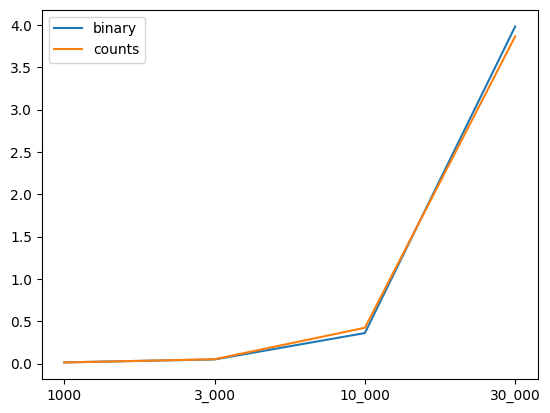

In [65]:
import matplotlib.pyplot as plt
on_list = [t[0]/60 for t in times]
on_heap = [t[1]/60 for t in times]
plt.plot(on_list, label="binary")
plt.plot(on_heap, label="counts")
plt.xticks([0, 1, 2, 3], labels=["1000", "3_000", "10_000", "30_000"])
plt.legend()

## Test Heap Based Sorting

In [77]:
corpus = ds['train'].take(10_000)['text'][:]

In [81]:
%%time
mhs = MinHash(10)
pairs1 = mhs.generate_scores(corpus)

100%|██████████| 10000/10000 [00:15<00:00, 636.63it/s]


CPU times: user 21 s, sys: 80 ms, total: 21 s
Wall time: 21 s


In [82]:
%%time
mhs = MinHash(10, use_h_queue=True)
pairs2 = mhs.generate_scores(corpus)

100%|██████████| 10000/10000 [00:20<00:00, 496.43it/s]

CPU times: user 25.3 s, sys: 64 ms, total: 25.4 s
Wall time: 25.4 s


In [83]:
sum1=0
for i in range(len(pairs1)):
    if pairs1[i][0]==pairs2[i][0] and pairs1[i][1]==pairs2[i][1]:
        sum1+=1
print(sum1)

1000


In [84]:
def test_hsort_scale(dims):
    times = []
    sums = []
    for dim in dims:
        corpus = ds['train'].take(dim)['text'][:]
        
        t0 = time.time()
        mhs = MinHash(10)
        pairs1 = mhs.generate_scores(corpus)
        
        t1 = time.time()
        mhs = MinHash(10, use_h_queue=True)
        pairs2 = mhs.generate_scores(corpus)
        
        t2 = time.time()
        
        times.append((t1-t0, t2-t1))
        
        sum1=0
        for i in range(len(pairs1)):
            if pairs1[i][0]==pairs2[i][0] and pairs1[i][1]==pairs2[i][1]:
                sum1+=1
        print(sum1)
        
        sums.append(sum1)
    return times, sums

In [85]:
times, sums = test_hsort_scale([1000, 3_000, 10_000, 30_000, 60_000])

100%|██████████| 1000/1000 [00:00<00:00, 4177.96it/s]


1000


100%|██████████| 3000/3000 [00:01<00:00, 2123.90it/s]


1000


100%|██████████| 10000/10000 [00:19<00:00, 523.25it/s]


1000


100%|██████████| 30000/30000 [03:22<00:00, 148.16it/s] 


1000


100%|██████████| 60000/60000 [13:28<00:00, 74.23it/s]  


1000


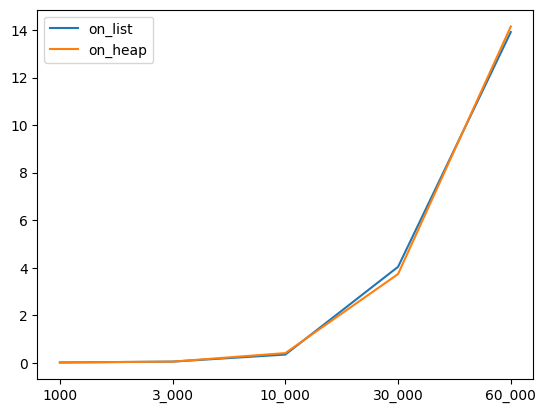

In [86]:
import matplotlib.pyplot as plt
on_list = [t[0]/60 for t in times]
on_heap = [t[1]/60 for t in times]
plt.plot(on_list, label="on_list")
plt.plot(on_heap, label="on_heap")
plt.xticks([0, 1, 2, 3, 4], labels=["1000", "3_000", "10_000", "30_000","60_000"])
plt.legend()

### Test heap on cache scaling

In [102]:
def test_hsort_cache_scale(dims, corpus_size = 30_000):
    times = []
    sums = []
    corpus = ds['train'].take(corpus_size)['text'][:]
    
    for dim in dims:
        t0 = time.time()
        mhs = MinHash(10, q_limit=dim)
        pairs1 = mhs.generate_scores(corpus)
        
        t1 = time.time()
        mhs = MinHash(10, q_limit=dim, use_h_queue=True)
        pairs2 = mhs.generate_scores(corpus)
        
        t2 = time.time()
        
        times.append((t1-t0, t2-t1))
        
        sum1=0
        for i in range(len(pairs1)):
            if pairs1[i][0]==pairs2[i][0] and pairs1[i][1]==pairs2[i][1]:
                sum1+=1
        print(sum1)
        
        sums.append(sum1)
    return times, sums

In [117]:
times, sums = test_hsort_cache_scale([1_000], corpus_size=10_000)

  0%|          | 28/10000 [00:00<01:07, 147.51it/s]

List is filled up!


  0%|          | 46/10000 [00:00<00:44, 225.38it/s]

Heap is filled up!


100%|██████████| 10000/10000 [00:21<00:00, 467.71it/s]

1000


In [118]:
times, sums = test_hsort_cache_scale([3_000], corpus_size=10_000)

  0%|          | 1/10000 [00:00<21:54,  7.61it/s]

List is filled up!


  1%|          | 57/10000 [00:00<00:34, 285.74it/s]

Heap is filled up!


100%|██████████| 10000/10000 [00:15<00:00, 631.09it/s]


3000


In [114]:
times, sums = test_hsort_cache_scale([10_000], corpus_size=10_000)

  0%|          | 0/10000 [00:00<?, ?it/s]

List is filled up!


  0%|          | 31/10000 [00:00<01:00, 164.20it/s]

Heap is filled up!


100%|██████████| 10000/10000 [00:21<00:00, 473.15it/s]


10000


In [115]:
times, sums = test_hsort_cache_scale([30_000], corpus_size=10_000)

  0%|          | 0/10000 [00:00<?, ?it/s]

List is filled up!


  0%|          | 27/10000 [00:00<01:11, 139.13it/s]

Heap is filled up!


100%|██████████| 10000/10000 [00:21<00:00, 472.77it/s]

30000


In [116]:
times, sums = test_hsort_cache_scale([60_000], corpus_size=10_000)

  0%|          | 0/10000 [00:00<?, ?it/s]

List is filled up!


  0%|          | 22/10000 [00:00<01:29, 111.10it/s]

Heap is filled up!


100%|██████████| 10000/10000 [00:21<00:00, 463.02it/s]


60000


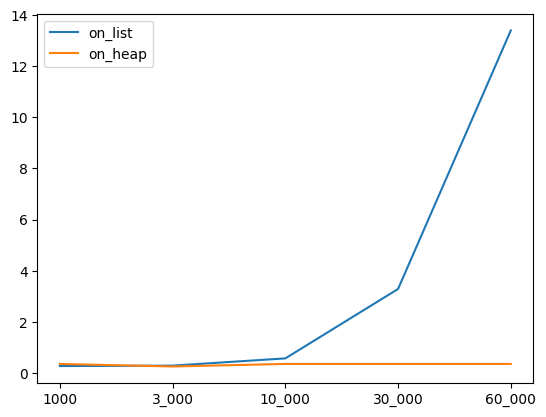

In [119]:
import matplotlib.pyplot as plt
on_list = [t/60 for t in [16,17,34,197,804]]
on_heap = [t/60 for t in [21,15,21,21,21]]
plt.plot(on_list, label="on_list")
plt.plot(on_heap, label="on_heap")
plt.xticks([0, 1, 2, 3, 4], labels=["1000", "3_000", "10_000", "30_000","60_000"])
plt.legend()

## Large Scale Test

In [120]:
corpus = ds['train']['text'][:]

In [121]:
len(corpus)

81708

In [122]:
mhs = MinHash(10, q_limit=30_000, use_h_queue=True)
pairs_large = mhs.generate_scores(corpus)

  0%|          | 4/81708 [00:00<2:46:23,  8.18it/s] 

Heap is filled up!


100%|██████████| 81708/81708 [23:19<00:00, 58.39it/s]  


In [156]:
pairs_large[0]

(76003, 78798, 1.0)

In [159]:
print(corpus[76003])

# OHAL Komisyonunun karar sayısı 92 bin oldu

## Özet

OHAL İşlemleri İnceleme Komisyonu, KHK ile meslekten ihraç edilenler, kapatılan kurum ve kuruluşlara ilişkin yapılan 126 bin 200 başvurudan 92 binini sonuçlandırdı.

## İçerik

#### OHAL İşlemleri İnceleme Komisyonu, KHK ile meslekten ihraç edilenler, kapatılan kurum ve kuruluşlara ilişkin yapılan 126 bin 200 başvurudan 92 binini sonuçlandırdı.
###### Ankara
Olağanüstü Hal (**OHAL** ) İşlemleri İnceleme Komisyonu, kanun hükmünde kararname (**KHK** ) ile bugüne kadar **meslekten ihraç ** edilenler, kapatılan bazı kurum ve kuruluşlara ilişkin yapılan 126 bin 200 başvurudan 92 binini karara bağladı.

Komisyondan yapılan yazılı açıklamaya göre, meslekten ihraç edilenler, bursu kesilen öğrenciler, rütbeleri alınan emekli güvenlik personeli, kapatılan kurum ile kuruluşlara ilişkin başvurulara bakmak üzere kurulan OHAL İşlemleri İnceleme Komisyonu'na 126 bin 200 müracaat yapıldı.

**OHAL İşlemleri İnceleme Komisyonu** , tamamlanan ve ince

In [160]:
print(corpus[78798])

# OHAL İşlemleri İnceleme Komisyonu, başvuruların yüzde 93'ünü sonuçlandırdı

## Özet

Komisyon, KHK ile meslekten ihraç edilenler, kapatılan kurum ve kuruluşlara ilişkin yapılan 126 bin 758 başvurudan 118 bin 415'ini karara bağladı.

## İçerik

#### Komisyon, KHK ile meslekten ihraç edilenler, kapatılan kurum ve kuruluşlara ilişkin yapılan 126 bin 758 başvurudan 118 bin 415'ini karara bağladı.
###### Ankara
Olağanüstü Hal (OHAL) İşlemleri İnceleme Komisyonu, kanun hükmünde kararname (KHK) ile bugüne kadar meslekten ihraç edilen ve kapatılan bazı kurum ve kuruluşlara ilişkin 126 bin 758 başvurudan 118 bin 415'ini sonuçlandırdı. Komisyon, sonuçlandırdığı başvurulardan 15 bin 50'sinde kabul kararı verdi.

Komisyondan yapılan açıklamaya göre, meslekten ihraç edilenler, bursu kesilen öğrenciler, rütbeleri alınan emekli güvenlik personeli, kapatılan kurum ile kuruluşlara ilişkin başvurulara bakmak üzere kurulan OHAL İşlemleri İnceleme Komisyonuna 126 bin 758 müracaat yapıldı.

Tamamlanan ve

In [323]:
k,h = A.shape

matches = np.zeros((k,k))

In [324]:
for i in range(k):
    matches = (A[i]-A[i+1:,:])==0
    matches[i,i+1:] += matches.sum(axis=1)